In [1]:
import pandas as pd

train = pd.read_csv("DailyDelhiClimateTrain.csv")
test = pd.read_csv("DailyDelhiClimateTest.csv")

train = train.merge(test, how="outer")

train["date"] = pd.to_datetime(train["date"])


inital_date = train["date"].min()
train["months_passed"] = (
    (train["date"].dt.year - inital_date.year) * 12
    + train["date"].dt.month
    - inital_date.month
)
mtrain = train.groupby("months_passed").mean()

means = {}
std_devs = {}
for column in mtrain.columns:
    if column == "date" or "months_passed" == column:
        continue
    means[column] = mtrain[column].mean()
    std_devs[column] = mtrain[column].std()
    mtrain[column] = (mtrain[column] - means[column]) / std_devs[column]

mtrain = mtrain.drop(columns=["date"]).reset_index()
data = mtrain.to_numpy()
train_data = data[:20, :]
test_data = data[20:, :]


def denormalize(data, key):
    return data * std_devs[key] + means[key]


print(mtrain.head())

   months_passed  meantemp  humidity  wind_speed  meanpressure
0              0 -1.874685  0.895009   -1.062248      0.219258
1              1 -1.191136  0.818410    0.286609      0.161962
2              2 -0.343023 -0.201837    0.942181      0.035058
3              3  0.524238 -1.804093    0.578992     -0.128888
4              4  1.220460 -2.202730    1.037301     -0.320751


In [2]:
import torch.nn as nn
import torch


class ODEfunc(nn.Module):
    def __init__(self, layers, input_size=4, output_size=4, activation=nn.CELU):
        super(ODEfunc, self).__init__()
        self.layers = [nn.Linear(input_size, layers[0]), activation()]
        for i in range(1, len(layers)):
            self.layers.append(nn.Linear(layers[i - 1], layers[i]))
            self.layers.append(activation())
        self.layers.append(nn.Linear(layers[-1], output_size))
        self.model = nn.Sequential(*self.layers)

    def forward(self, x, z):
        return self.model(z)


from torchdiffeq import odeint


class NeuralODE(nn.Module):
    def __init__(self, layers, input_size=4, output_size=4, activation=nn.CELU):
        super(NeuralODE, self).__init__()
        self.func = ODEfunc(layers, input_size, output_size, activation)

    def forward(self, z0, t):
        return odeint(self.func, z0, t)


class GLLNeuralODE(nn.Module):
    def __init__(
        self,
        layers,
        input_size=4,
        output_size=4,
        hidden_layer_size=32,
        activation=nn.CELU,
    ):
        super(GLLNeuralODE, self).__init__()
        self.func = ODEfunc(layers, input_size, output_size, activation)
        self.conflayer = nn.Sequential(
            *[
                nn.Linear(input_size, hidden_layer_size),
                activation(),
                nn.Linear(hidden_layer_size, hidden_layer_size),
                activation(),
                nn.Linear(hidden_layer_size, output_size),
            ]
        )

    def forward(self, z0, t):
        output = odeint(self.func, z0, t)
        confout = torch.exp(self.conflayer(output))
        return output, confout


import matplotlib.pyplot as plt


def plot_data(x, ys, xpts, ypts, ytrue):
    y1 = ys[:, 0]
    y2 = ys[:, 1]
    y3 = ys[:, 2]
    y4 = ys[:, 3]
    y1 = denormalize(y1, "meantemp")
    y2 = denormalize(y2, "humidity")
    y3 = denormalize(y3, "wind_speed")
    y4 = denormalize(y4, "meanpressure")

    # ypts1 = ypts[:, 0]
    # ypts2 = ypts[:, 1]
    # ypts3 = ypts[:, 2]
    # ypts4 = ypts[:, 3]

    ytrue1 = ytrue[:, 0]
    ytrue2 = ytrue[:, 1]
    ytrue3 = ytrue[:, 2]
    ytrue4 = ytrue[:, 3]
    ytrue1 = denormalize(ytrue1, "meantemp")
    ytrue2 = denormalize(ytrue2, "humidity")
    ytrue3 = denormalize(ytrue3, "wind_speed")
    ytrue4 = denormalize(ytrue4, "meanpressure")

    plt.figure()
    plt.title("mean temperature")
    plt.plot(x, y1, label="mean temperature")
    # plt.scatter(xpts, ypts1, color="red", label="data predictions")
    plt.scatter(xpts, ytrue1, color="green", label="true data")
    plt.legend()
    plt.show()

    plt.figure()
    plt.title("mean humidity")
    plt.plot(x, y2, label="mean humidity")
    # plt.scatter(xpts, ypts2, color="red", label="data predictions")
    plt.scatter(xpts, ytrue2, color="green", label="true data")
    plt.legend()
    plt.show()

    plt.figure()
    plt.title("mean wind speed")
    plt.plot(x, y3, label="mean wind speed")
    # plt.scatter(xpts, ypts3, color="red", label="data predictions")
    plt.scatter(xpts, ytrue3, color="green", label="true data")
    plt.legend()
    plt.show()

    plt.figure()
    plt.title("mean pressure")
    plt.plot(x, y4, label="mean pressure")
    # plt.scatter(xpts, ypts4, color="red", label="data predictions")
    plt.scatter(xpts, ytrue4, color="green", label="true data")
    plt.legend()
    plt.show()


def plt_step(model, pts, y0, xmax=30):
    x = torch.linspace(0, xmax, 121)
    with torch.no_grad():
        # preds, _ = model(y0, x.double())
        preds = model(y0, x.double())
        # preds = preds.detach().numpy()
        # pt_preds, _ = model(y0, torch.tensor(pts[:, 0]))
        pt_preds = model(y0, torch.tensor(pts[:, 0]))
        # pt_preds = pt_preds.detach().numpy()
        true_pts = pts[:, 1:]

    plot_data(x, preds, pts[:, 0], pt_preds, true_pts)

True
Phase 0


C:\Users\romrellb\AppData\Local\Temp\ipykernel_27112\2096036633.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y0 = torch.tensor(train_data[0, 1:]).double().cuda()
C:\Users\romrellb\AppData\Local\Temp\ipykernel_27112\2096036633.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(train_data).double().cuda()


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\romrellb\AppData\Local\Temp\ipykernel_27112\1007966695.py:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pt_preds = model(y0, torch.tensor(pts[:, 0]))


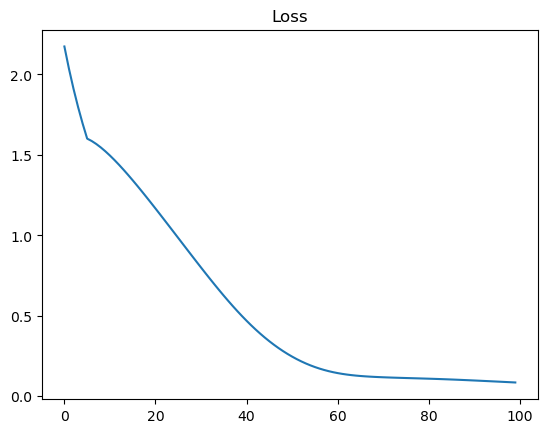

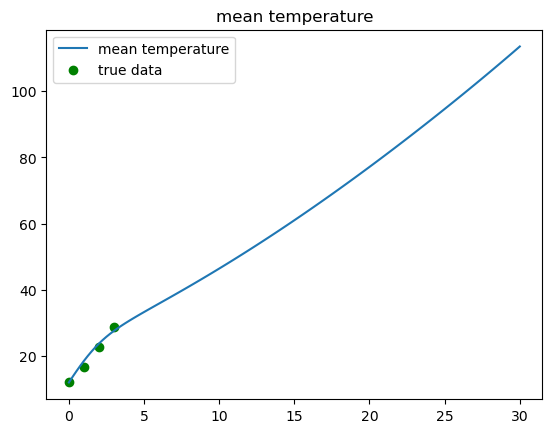

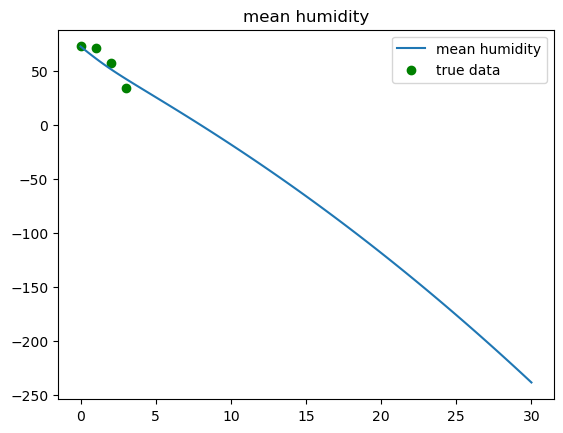

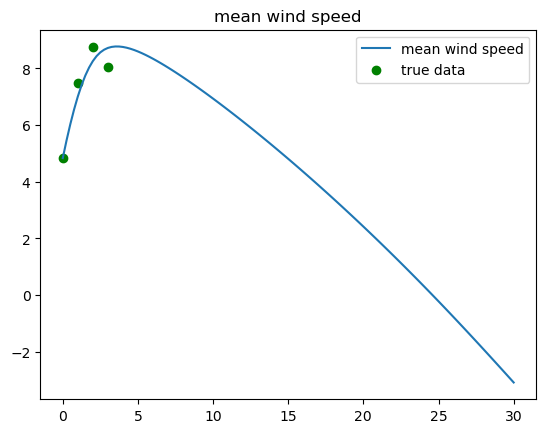

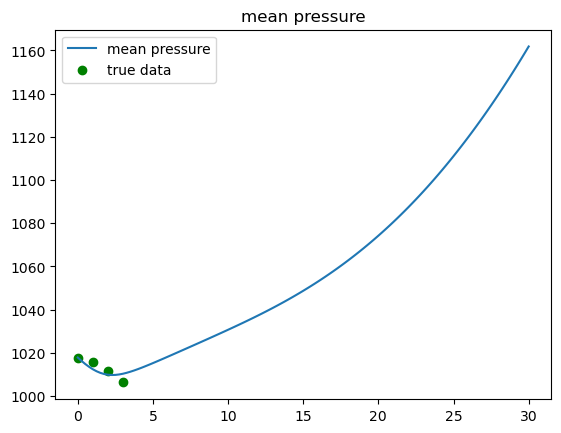

Phase 1


  0%|          | 0/250 [00:00<?, ?it/s]

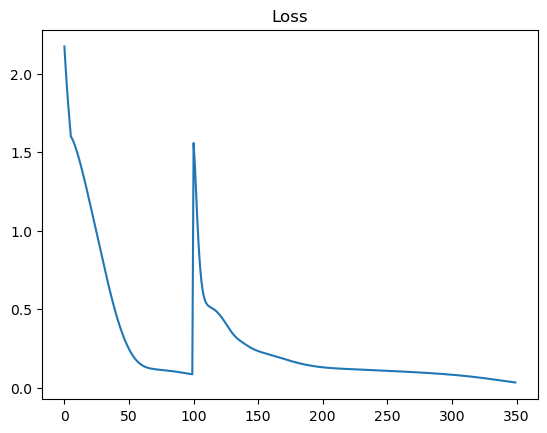

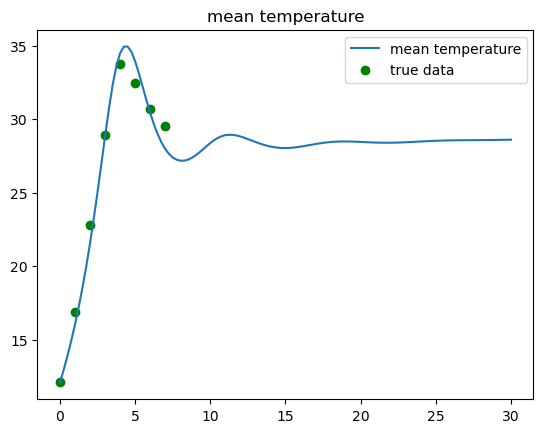

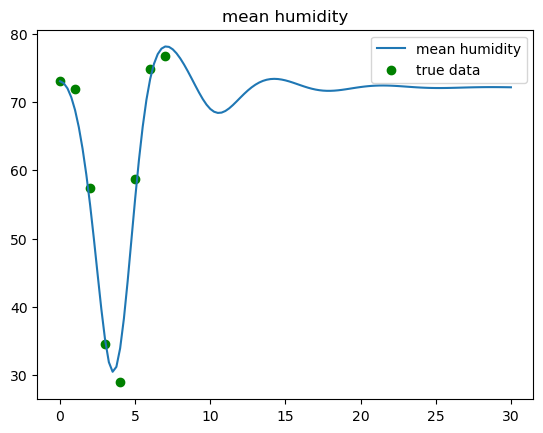

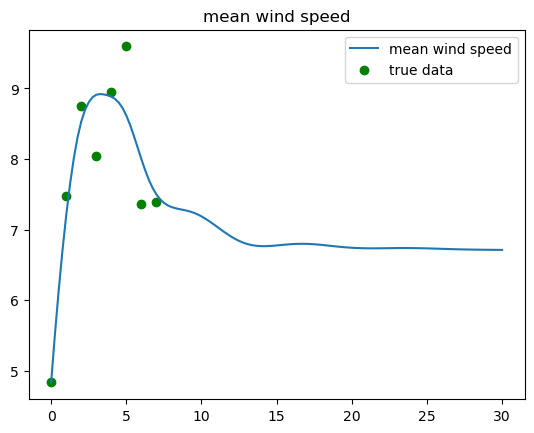

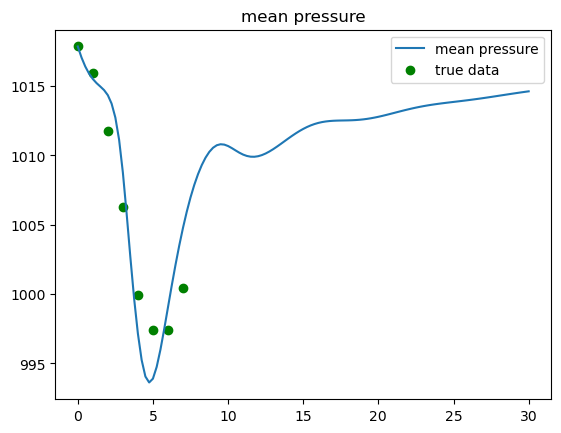

Phase 2


  0%|          | 0/250 [00:00<?, ?it/s]

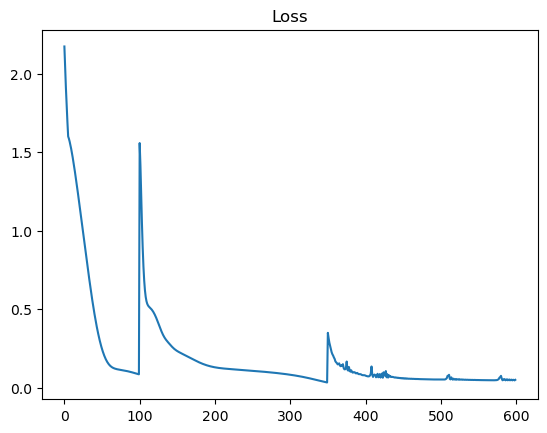

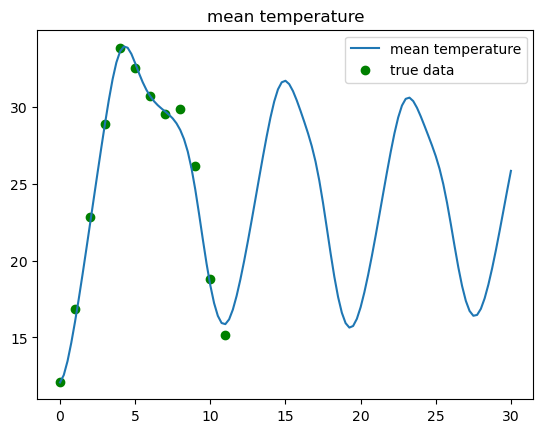

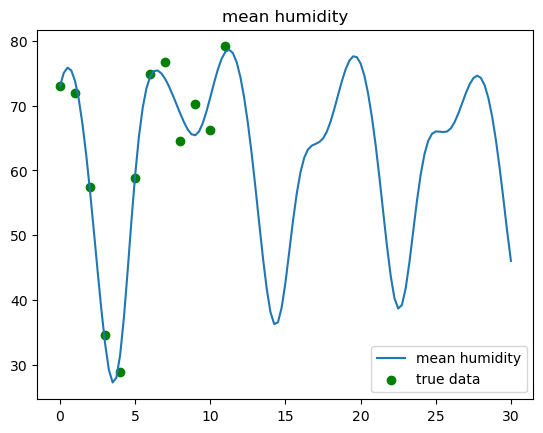

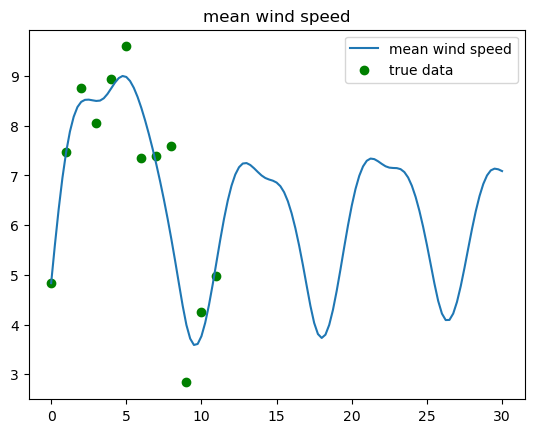

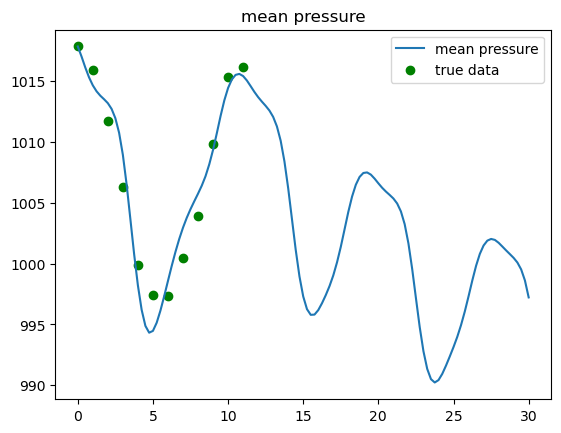

Phase 3


  0%|          | 0/250 [00:00<?, ?it/s]

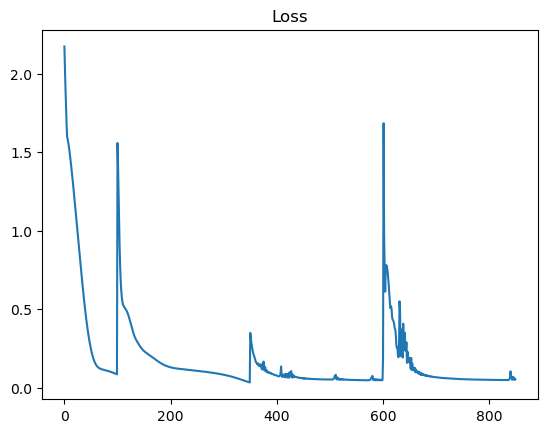

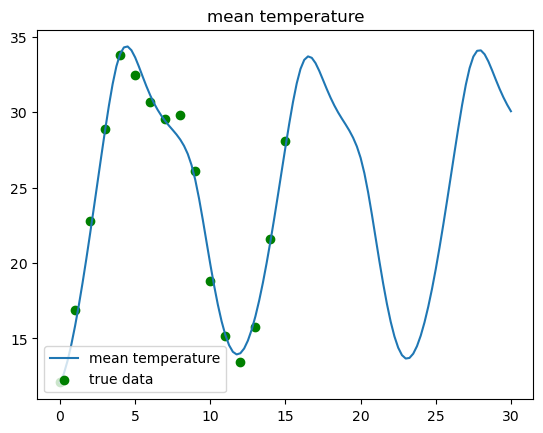

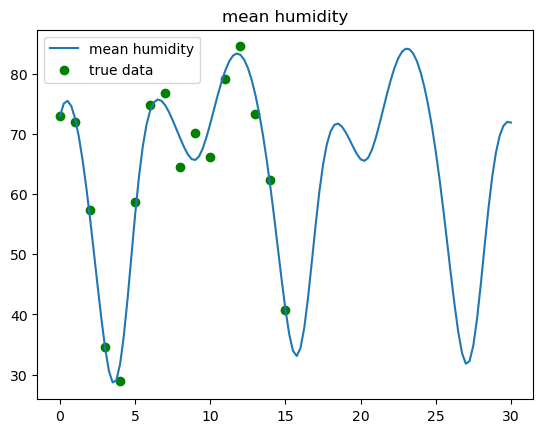

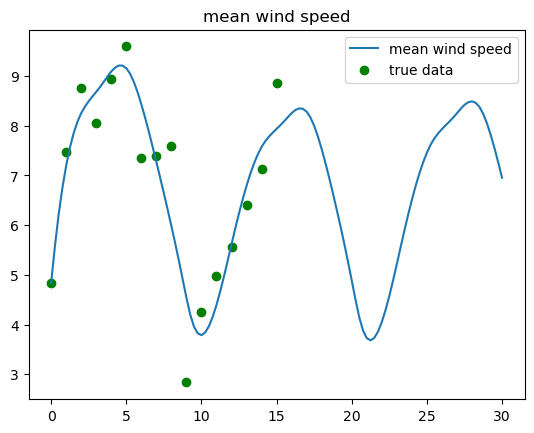

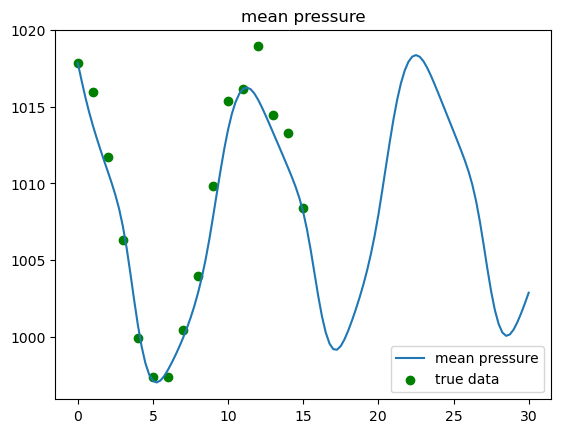

Phase 4


  0%|          | 0/500 [00:00<?, ?it/s]

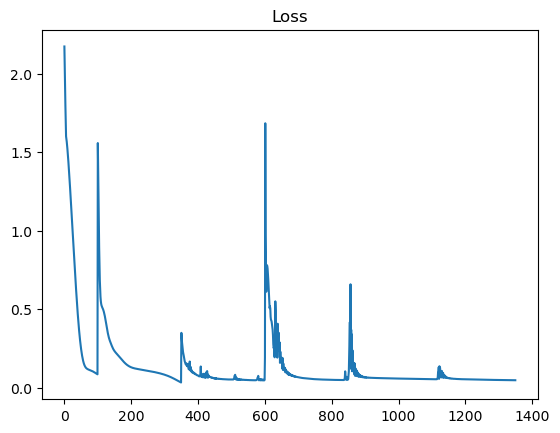

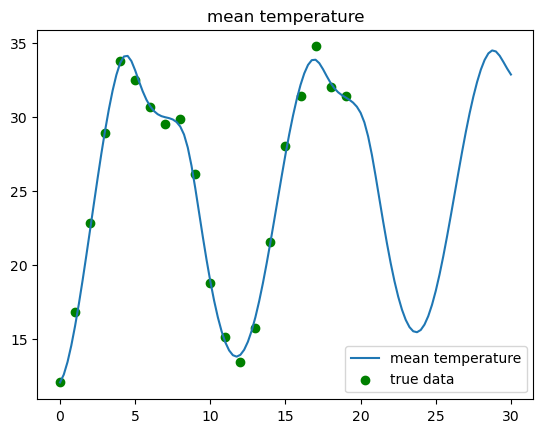

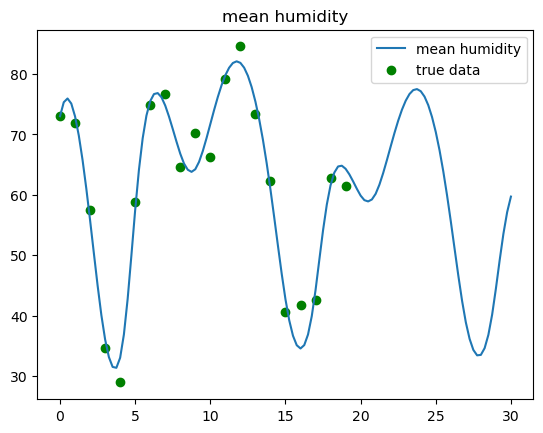

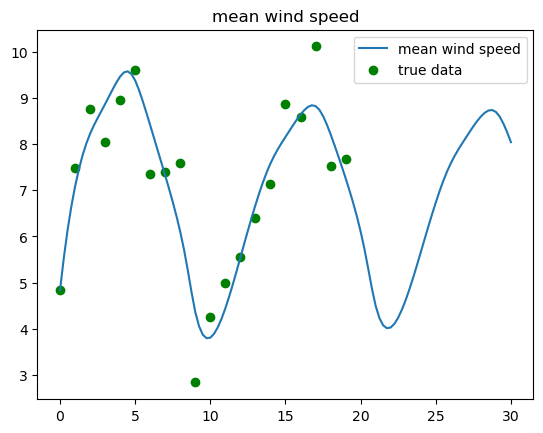

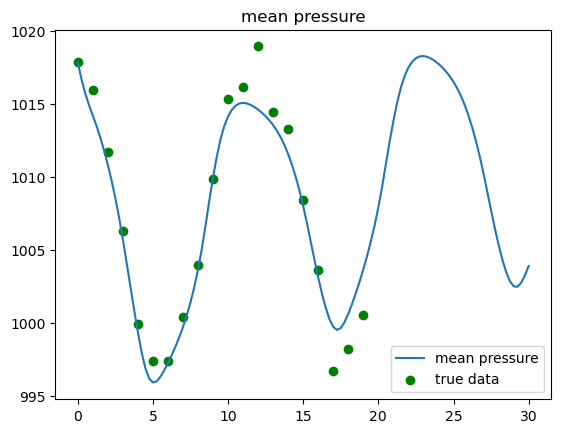

In [5]:
from tqdm.notebook import tqdm
# phases = [100, 250, 200, 500, 800]
# lrs = [1e-3, 1e-3, 1e-3, 4e-3, 2e-3]

phases = [100, 250, 250, 250, 500]
lrs = [4e-2, 3e-2, 2e-2, 1e-2, 2e-2]

model = NeuralODE([64, 32, 32, 32]).double().cuda()
# model = GLLNeuralODE([48, 32]).double().cuda()

y0 = torch.tensor(train_data[0, 1:]).double().cuda()
y0cpu = y0.clone().detach().cpu()

optim = torch.optim.RAdam(model.parameters(), lr=4e-3, weight_decay=1e-9)
loss = nn.MSELoss()
# loss = nn.GaussianNLLLoss(reduction="sum")


def set_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def reduce_lr(optimizer, factor):
    for param_group in optimizer.param_groups:
        param_group["lr"] *= factor


losses = []


train_data = torch.tensor(train_data).double().cuda()

print(torch.cuda.is_available())

for i, epochs in enumerate(phases):
    print("Phase", i)
    # set_lr(optim, lrs[i])
    model.cuda()

    tq = tqdm(total=epochs)
    for epoch in range(epochs):
        # if i != 0 and epoch < 20:
        #     set_lr(optim, lrs[i] / 100)
        # elif epoch == 10:
        #     set_lr(optim, lrs[i])
        optim.zero_grad()

        x = train_data[: min(4 * (i + 1), len(train_data[:, 0])), 0]

        y = train_data[: min(4 * (i + 1), len(train_data[:, 0])), 1:]
        # y_pred, conf = model(y0, x)
        y_pred = model(y0, x)

        l = loss(y_pred, y)  # , conf)

        l.backward()

        optim.step()
        tq.update(1)

        losses.append(l.item())
        # if epoch % (epochs // 9) == 0 and epoch != 0:
        #     reduce_lr(optim, 0.4)
        # if epoch % (epochs // 4) == 0 and epoch != 0:
        #     set_lr(optim, lrs[i] * 1.2)

    plt.figure()

    plt.title("Loss")
    plt.plot(losses)

    plt_step(
        model.cpu(), train_data[: 4 * (i + 1)].clone().detach().cpu(), y0cpu
    )

Test set


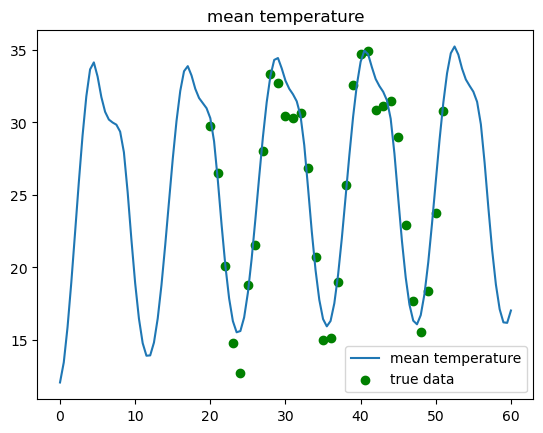

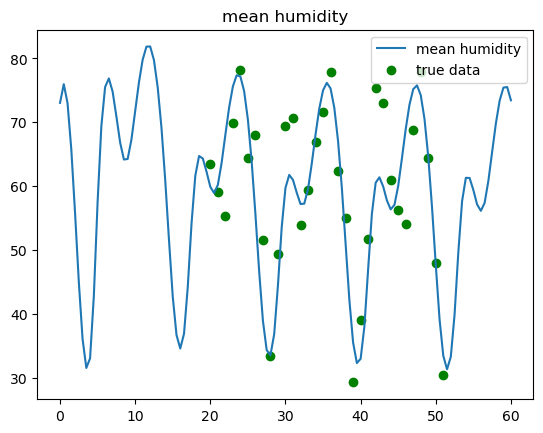

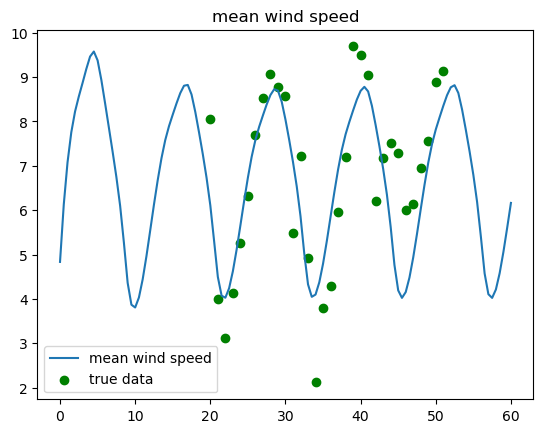

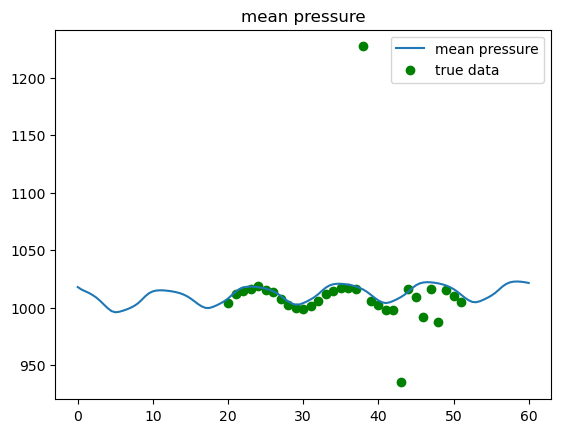

MSE 2.401515711879451


In [ ]:
print("Test set")
plt_step(model, test_data, y0cpu, xmax=60)
test_t = torch.tensor(test_data[:, 0]).double()
test_y = torch.tensor(test_data[:, 1:]).double()

model.cpu()
test_preds = model(y0cpu, test_t).detach().numpy()
test_true = test_y.numpy()
mse = loss(torch.tensor(test_preds), test_y).item()
print("MSE", mse)

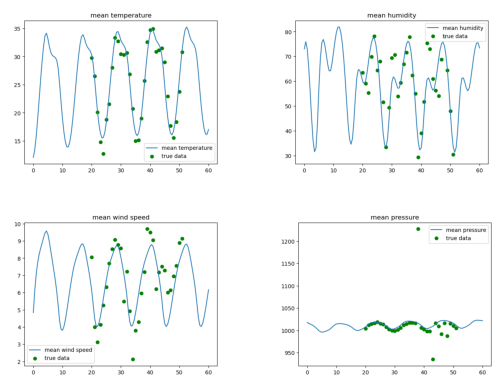

In [12]:
img1 = plt.imread("fig6-1.png")
img2 = plt.imread("fig6-2.png")
img3 = plt.imread("fig6-3.png")
img4 = plt.imread("fig6-4.png")

imgs = [img1, img2, img3, img4]
fig, axes = plt.subplots(2, 2)
for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i])
    ax.axis("off")
plt.show()